In [1]:
import pandas as pd 
from sklearn.linear_model import RidgeCV, LinearRegression, Ridge, Lasso, LassoLarsCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error

In [2]:
raw_data = pd.read_csv('../data/output/mannheim_transformed.csv')

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198384 entries, 0 to 198383
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   bike_number          198384 non-null  int64 
 1   start_time           198384 non-null  object
 2   weekend              198384 non-null  bool  
 3   start_position       198384 non-null  object
 4   start_position_name  198384 non-null  object
 5   duration             198384 non-null  int64 
 6   end_time             198384 non-null  object
 7   end_position         198384 non-null  object
 8   end_position_name    198384 non-null  object
 9   is_station           198384 non-null  bool  
dtypes: bool(2), int64(2), object(6)
memory usage: 12.5+ MB


In [57]:
raw_data.loc[raw_data['is_station']==True , 'start_position_name'].nunique()

48

In [5]:
#raw_data.loc[raw_data['duration']>10920].set_index('start_time')['duration'].plot(figsize=(15,15))

In [6]:
# I remove all trips that are shorter or equal to 180 seconds and which have the same start and end position
raw_data.loc[(raw_data['duration']<=180) & (raw_data["start_position"] == raw_data["end_position"])]

,bike_number,start_time,weekend,start_position,start_position_name,duration,end_time,end_position,end_position_name,is_station
0,20234,2019-09-15 03:56:00,True,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,120,2019-09-15 03:58:00,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,True
1,20234,2019-09-15 05:13:00,True,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,120,2019-09-15 05:15:00,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,True
2,20234,2019-09-15 11:26:00,True,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,120,2019-09-15 11:28:00,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,True
7,20234,2019-09-17 11:20:00,False,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,120,2019-09-17 11:22:00,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,True
8,20234,2019-09-17 11:59:00,False,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,120,2019-09-17 12:01:00,POINT (8.533989787101746 49.47347157505978),DHBW Mannheim - Campus Coblitzallee,True
...,...,...,...,...,...,...,...,...,...,...
198379,430399,2019-12-26 21:45:00,False,POINT (8.496122360229492 49.47735808687585),Technoseum,120,2019-12-26 21:47:00,POINT (8.496122360229492 49.47735808687585),Technoseum,True
198380,430399,2019-12-28 14:47:00,True,POINT (8.496122360229492 49.47735808687585),Technoseum,120,2019-12-28 14:49:00,POINT (8.496122360229492 49.47735808687585),Technoseum,True
198381,430399,2019-12-28 22:58:00,True,POINT (8.496122360229492 49.47735808687585),Technoseum,120,2019-12-28 23:00:00,POINT (8.496122360229492 49.47735808687585),Technoseum,True
198382,430399,2019-12-29 02:55:00,True,POINT (8.496122360229492 49.47735808687585),Technoseum,120,2019-12-29 02:57:00,POINT (8.496122360229492 49.47735808687585),Technoseum,True


In [7]:
col_to_drop = ['bike_number','start_position','end_time','end_position','end_position_name']
prediction_data = raw_data.drop(columns=col_to_drop).loc[(raw_data['duration']>180) | (raw_data["start_position"] != raw_data["end_position"])]

In [8]:
prediction_data.loc[(raw_data['duration']<180)]

,start_time,weekend,start_position_name,duration,is_station
137,2019-08-08 11:11:00,False,BIKE 42800,120,False
289,2019-05-07 05:05:00,False,Lindenhof - Johanniskirche,120,True
525,2019-06-05 11:59:00,False,E1 - Paradeplatz,120,False
659,2019-04-24 14:27:00,False,Hauptbahnhof Mannheim,120,False
712,2019-05-04 16:08:00,True,Theresienkrankenhaus,120,True
...,...,...,...,...,...
197715,2019-09-09 08:55:00,False,E1 - Paradeplatz,120,True
197716,2019-09-09 10:14:00,False,E4 - Rathaus,120,True
197752,2019-08-04 11:36:00,True,BIKE 430396,120,False
197835,2019-09-06 07:50:00,False,BIKE 430396,120,False


In [9]:
prediction_data['start_time'] = pd.to_datetime(prediction_data.start_time)

In [10]:
#from scipy import stats
#z = np.abs(stats.zscore(prediction_data['duration']))
#prediction_data = prediction_data[(z < 3)]

In [11]:
#Q1 = prediction_data['duration'].quantile(0.25)
#Q3 = prediction_data['duration'].quantile(0.75)
#IQR = Q3 - Q1

In [12]:
#mask = prediction_data['duration'].between((Q1 - 1.5 * IQR), (Q3 + 1.5 * IQR), inclusive=True)
#iqr = prediction_data.loc[mask]

In [13]:
#iqr.describe()

,duration
count,138487.000000
mean,652.824453
std,344.363389
min,120.000000
25%,420.000000
50%,540.000000
75%,840.000000
max,1740.000000


In [14]:
prediction_data = iqr.copy()

In [15]:
# Creating an individual column for hour of the day
prediction_data['HOUR'] = prediction_data.start_time.dt.strftime('%-H').astype('int')

# Creating an individual column for week of the year
prediction_data['WEEK_OF_YEAR'] = prediction_data.start_time.dt.strftime('%W').astype('int')

# Creating an individual column for day of the week
prediction_data['DAY_OF_WEEK'] = prediction_data.start_time.dt.strftime('%w').astype('int')

seasons = []
for month in prediction_data.start_time.dt.strftime('%m').astype('int'):
    if month in [1, 2, 12]:
        seasons.append('WINTER')
    elif month in [3, 4, 5]:
        seasons.append('SPRING')
    elif month in [6, 7, 8]:
        seasons.append('SUMMER')
    elif month in [9, 10, 11]:
        seasons.append('FALL')
prediction_data['season'] = seasons

In [16]:
# Creating fig and subplots
#fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharex=True, sharey=True, dpi=500)

# Plotting the relationship between the actual count and its lagged values
#for i, ax in enumerate(axes.flatten()[:10]):
#    pd.plotting.lag_plot(raw_data.sort_values(by=['start_time'])['duration'], lag=i + 1, ax=ax)
#    ax.set_title('Lag ' + str(i + 1))
#plt.tight_layout();

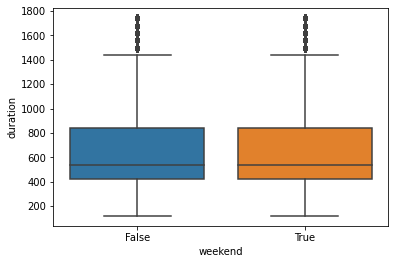

In [17]:
sns.boxplot(x='weekend', y='duration', data=prediction_data)

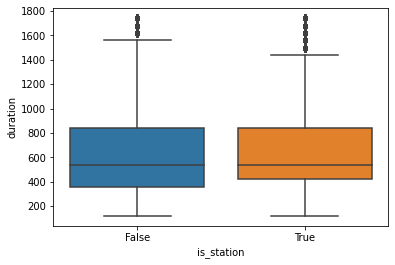

In [18]:
sns.boxplot(x='is_station', y='duration', data=prediction_data)

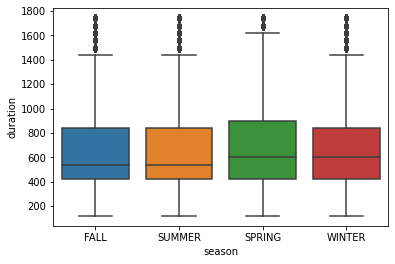

In [19]:
sns.boxplot(x='season', y='duration', data=prediction_data)

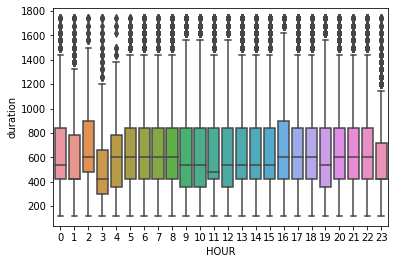

In [20]:
sns.boxplot(x='HOUR', y='duration', data=prediction_data)

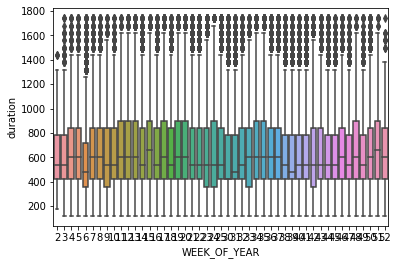

In [21]:
sns.boxplot(x='WEEK_OF_YEAR', y='duration', data=prediction_data)

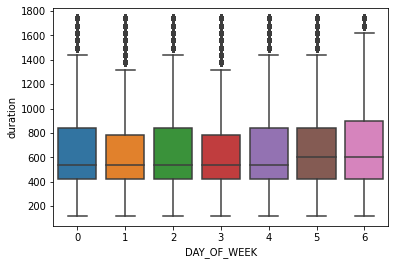

In [22]:
sns.boxplot(x='DAY_OF_WEEK', y='duration', data=prediction_data)

In [23]:
# Applying sine,cosine transformation on column hour to retain the cyclical nature
prediction_data['HOUR_SIN'] = np.sin(prediction_data.HOUR * (2. * np.pi / 24))
prediction_data['HOUR_COS'] = np.cos(prediction_data.HOUR * (2. * np.pi / 24))

In [24]:
# Applying sine,cosine transformation on column WEEK_OF_YEAR to retain the cyclical nature
prediction_data['WEEK_OF_YEAR_SIN'] = np.sin(prediction_data.WEEK_OF_YEAR * (2. * np.pi / 52))
prediction_data['WEEK_OF_YEAR_COS'] = np.cos(prediction_data.WEEK_OF_YEAR * (2. * np.pi / 52))

In [25]:
# Applying sine,cosine transformation on column DAY_OF_WEEK to retain the cyclical nature
prediction_data['DAY_OF_WEEK_SIN'] = np.sin(prediction_data.DAY_OF_WEEK * (2. * np.pi / 7))
prediction_data['DAY_OF_WEEK_COS'] = np.cos(prediction_data.DAY_OF_WEEK * (2. * np.pi / 7))

In [26]:
# hier muss kein drop first weil es ja noch floating starts gibt
station_dummies = pd.get_dummies(prediction_data.loc[raw_data['is_station']==True , 'start_position_name'])

In [27]:
station_dummies

,(inoff) Bohnenbergerstraße 17,A5 - Universität West,DHBW Mannheim - Campus Coblitzallee,DHBW Mannheim - Campus Käfertalerstr.,E1 - Paradeplatz,E4 - Rathaus,Franklin,G7 - Westliche Unterstadt,Gewerkschaftshaus,Hauptbahnhof Mannheim,...,Schwetzingerstadt - rnv Betriebshof Möhlstraße,Studentensiedlung Ludwig Frank,Technoseum,Theresienkrankenhaus,Traitteurstraße,Universität Mensa,Universität Schloss,Universitätsklinik Mannheim - CampusRad,VRNnextbike Eventstation,Willy-Brandt-Platz 68161 Mannheim
5,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198375,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
seasonal_dummies = pd.get_dummies(prediction_data['season'], drop_first=True)

In [29]:
# Dropping individual time columns since their transformation will be used
prediction_data.drop(columns=['WEEK_OF_YEAR', 'DAY_OF_WEEK', 'HOUR','start_time','season','start_position_name'], axis=1, inplace=True)

In [30]:
prediction_data = pd.concat([prediction_data, seasonal_dummies, station_dummies], axis=1)

In [31]:
prediction_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138487 entries, 4 to 198376
Data columns (total 60 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   weekend                                         138487 non-null  bool   
 1   duration                                        138487 non-null  int64  
 2   is_station                                      138487 non-null  bool   
 3   HOUR_SIN                                        138487 non-null  float64
 4   HOUR_COS                                        138487 non-null  float64
 5   WEEK_OF_YEAR_SIN                                138487 non-null  float64
 6   WEEK_OF_YEAR_COS                                138487 non-null  float64
 7   DAY_OF_WEEK_SIN                                 138487 non-null  float64
 8   DAY_OF_WEEK_COS                                 138487 non-null  float64
 9   SPRING                    

In [32]:
prediction_data.fillna(0.0, inplace=True)

In [33]:
X = prediction_data.drop(columns=['duration'])
y = prediction_data['duration'].values.reshape(-1,1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [35]:
target_transformer = StandardScaler().fit(y_train)
y_train = target_transformer.transform(y_train)

In [36]:
model = LassoLarsCV(cv=5, normalize=False).fit(X_train, y_train)

/mnt/Sharedrive/Development/University/SS20/PDS_Project/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
y_pred = target_transformer.inverse_transform(model.predict(X_train).reshape(-1, 1))

In [38]:
reg_residuals = target_transformer.inverse_transform(y_train.reshape(-1, 1)) - y_pred

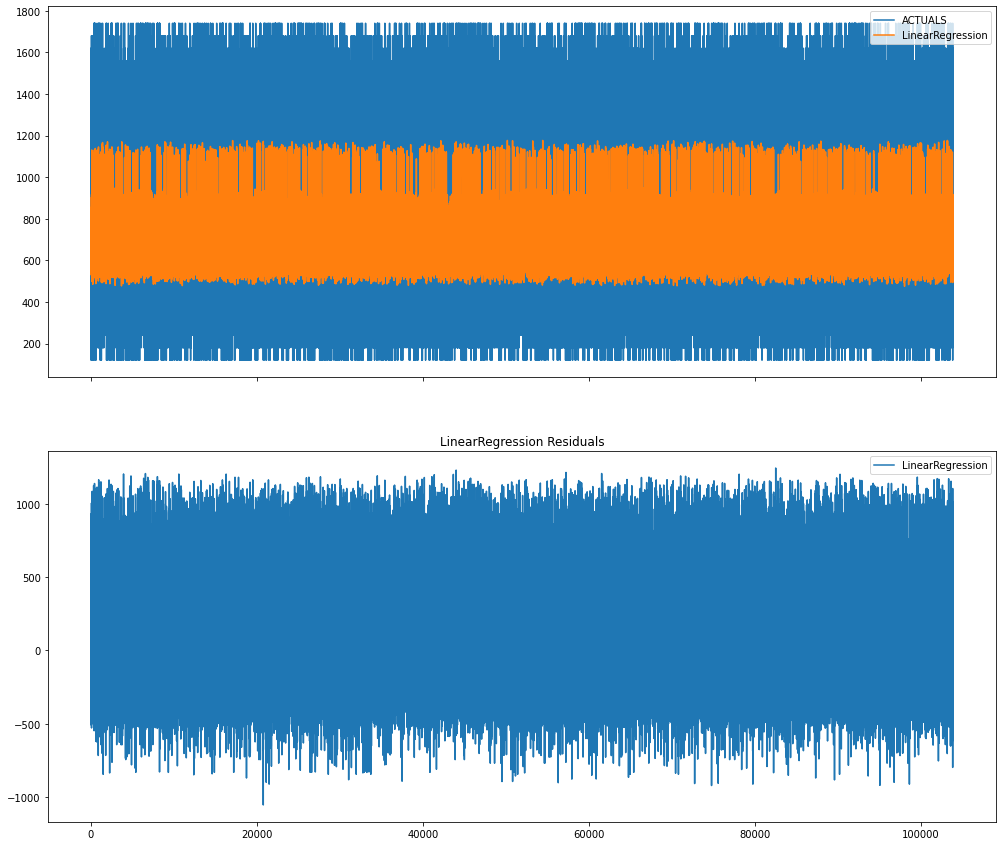

In [39]:
# Creating fit and subplots
fix, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=True)

# Plotting actuals and fit of linear and random forest regression
pd.DataFrame({'ACTUALS': target_transformer.inverse_transform(y_train.reshape(-1, 1)).reshape(-1),
              'LinearRegression': y_pred.reshape(-1)}).plot(ax=axs[0])


# Plotting residuals of linear and random forest regression
pd.DataFrame({'LinearRegression': reg_residuals.reshape(-1)}).plot(ax=axs[1])

axs[1].set_title('LinearRegression Residuals');

In [40]:
mean_absolute_error(target_transformer.inverse_transform(y_train), y_pred)

257.96043258184005

In [41]:
rf_model = RandomForestRegressor(n_jobs=-1, 
                                 random_state=123)

In [42]:
rf_model.fit(X_train, y_train)

/mnt/Sharedrive/Development/University/SS20/PDS_Project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [43]:
# Calculating the fit of the model
rf_predictions = target_transformer.inverse_transform(rf_model.predict(X_train).reshape(-1, 1))



# Calculating the residuals
rf_residuals = target_transformer.inverse_transform(y_train.reshape(-1, 1)) - rf_predictions

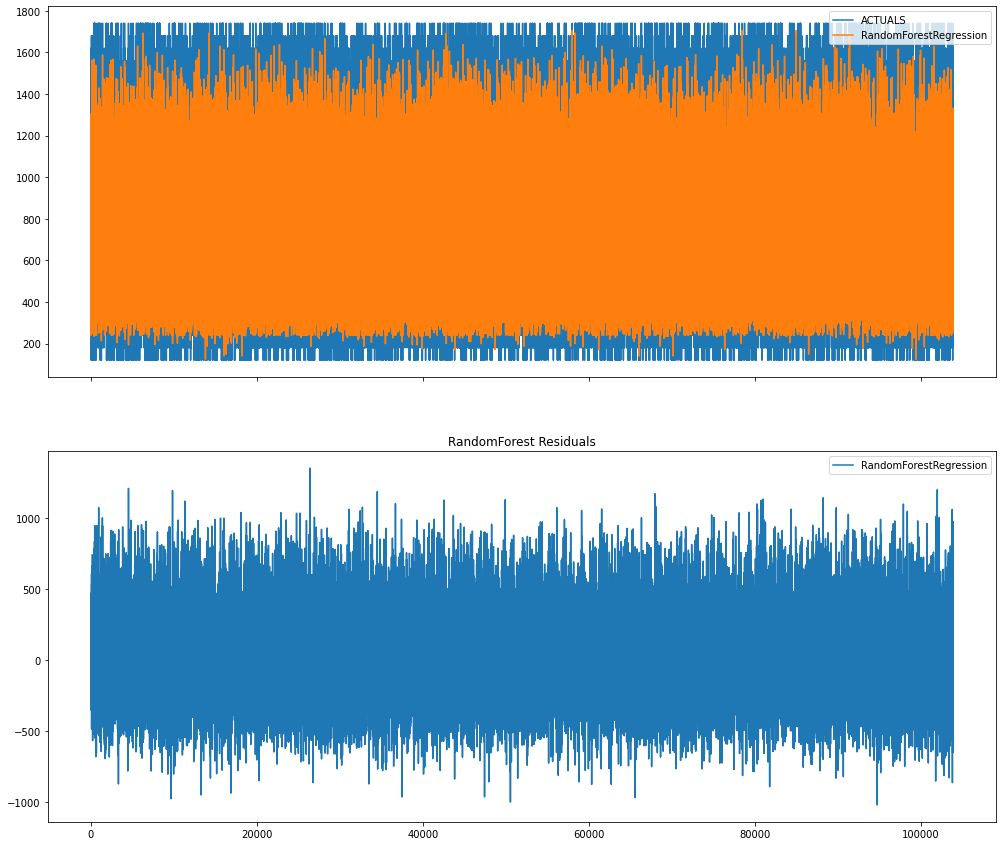

In [44]:
# Creating fit and subplots
fix, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=True)

# Plotting actuals and fit of linear and random forest regression
pd.DataFrame({'ACTUALS': target_transformer.inverse_transform(y_train.reshape(-1, 1)).reshape(-1),
              'RandomForestRegression': rf_predictions.reshape(-1)}).plot(ax=axs[0])


# Plotting residuals of linear and random forest regression
pd.DataFrame({'RandomForestRegression': rf_residuals.reshape(-1)}).plot(ax=axs[1])

axs[1].set_title('RandomForest Residuals');

In [45]:
mean_absolute_error(target_transformer.inverse_transform(y_train.reshape(-1, 1)), rf_predictions)

137.28411461669967

In [46]:
rf_mode_opt = RandomForestRegressor(n_jobs=-1, 
                                 random_state=123,
                                 n_estimators=800,
                                 min_samples_split=10,
                                 min_samples_leaf=4,
                                 max_features='sqrt',
                                 max_depth=80,
                                 bootstrap=True)

In [47]:
rf_mode_opt.fit(X_train, y_train)

/mnt/Sharedrive/Development/University/SS20/PDS_Project/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=800, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)

In [48]:
# Calculating the fit of the model
rf_opt_predictions = target_transformer.inverse_transform(rf_mode_opt.predict(X_train).reshape(-1, 1))



# Calculating the residuals
rf_opt_residuals = target_transformer.inverse_transform(y_train.reshape(-1, 1)) - rf_opt_predictions

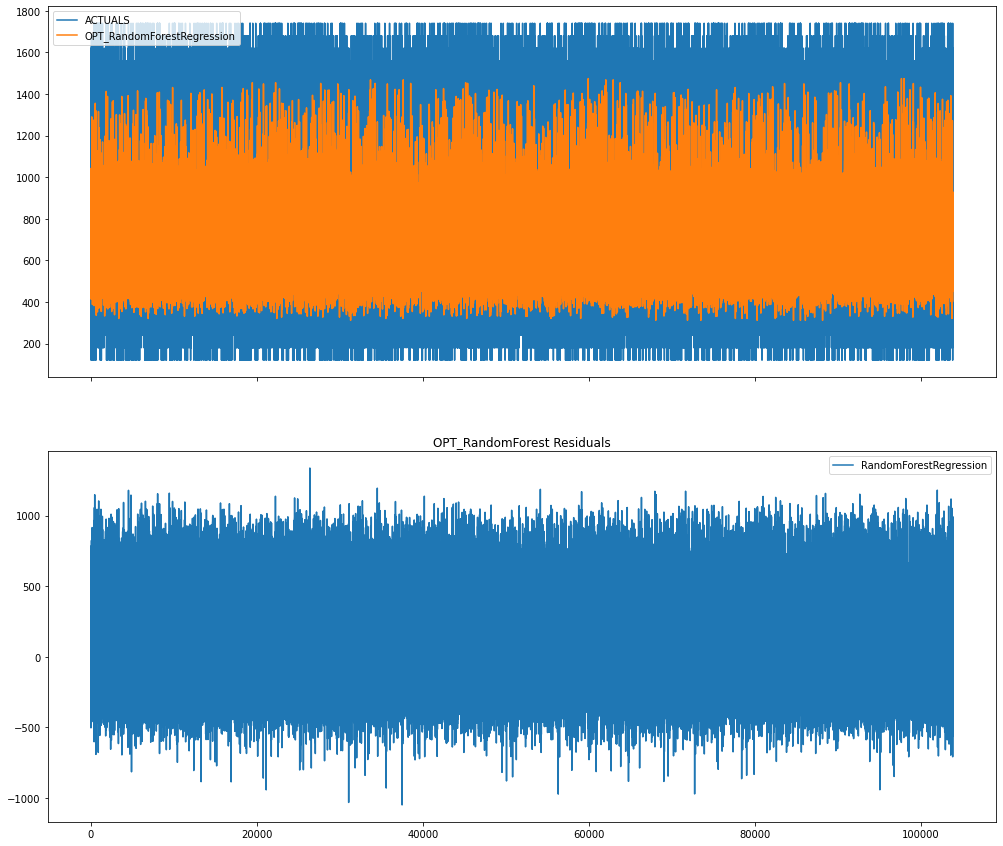

In [49]:
# Creating fit and subplots
fix, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=True)

# Plotting actuals and fit of linear and random forest regression
pd.DataFrame({'ACTUALS': target_transformer.inverse_transform(y_train.reshape(-1, 1)).reshape(-1),
              'OPT_RandomForestRegression': rf_opt_predictions.reshape(-1)}).plot(ax=axs[0])


# Plotting residuals of linear and random forest regression
pd.DataFrame({'RandomForestRegression': rf_opt_residuals.reshape(-1)}).plot(ax=axs[1])

axs[1].set_title('OPT_RandomForest Residuals');

In [50]:
station_dummies.describe()

,(inoff) Bohnenbergerstraße 17,A5 - Universität West,DHBW Mannheim - Campus Coblitzallee,DHBW Mannheim - Campus Käfertalerstr.,E1 - Paradeplatz,E4 - Rathaus,Franklin,G7 - Westliche Unterstadt,Gewerkschaftshaus,Hauptbahnhof Mannheim,...,Schwetzingerstadt - rnv Betriebshof Möhlstraße,Studentensiedlung Ludwig Frank,Technoseum,Theresienkrankenhaus,Traitteurstraße,Universität Mensa,Universität Schloss,Universitätsklinik Mannheim - CampusRad,VRNnextbike Eventstation,Willy-Brandt-Platz 68161 Mannheim
count,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,...,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000,127309.000000
mean,0.000016,0.066099,0.010958,0.007093,0.046745,0.017296,0.001681,0.015835,0.017328,0.112883,...,0.015843,0.032072,0.005907,0.005718,0.000008,0.025222,0.052070,0.015191,0.000888,0.000008
std,0.003964,0.248456,0.104104,0.083921,0.211092,0.130374,0.040965,0.124839,0.130491,0.316451,...,0.124870,0.176191,0.076629,0.075404,0.002803,0.156800,0.222169,0.122314,0.029780,0.002803
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
raw_data.describe()

,bike_number,duration
count,198384.000000,198384.000000
mean,187323.377475,1043.463283
std,186857.532441,3298.136093
min,20234.000000,120.000000
25%,43385.000000,180.000000
50%,44009.000000,480.000000
75%,430116.000000,840.000000
max,430399.000000,85980.000000


In [52]:
mean_absolute_error(target_transformer.inverse_transform(y_train.reshape(-1, 1)), rf_opt_predictions)

215.83823239149748

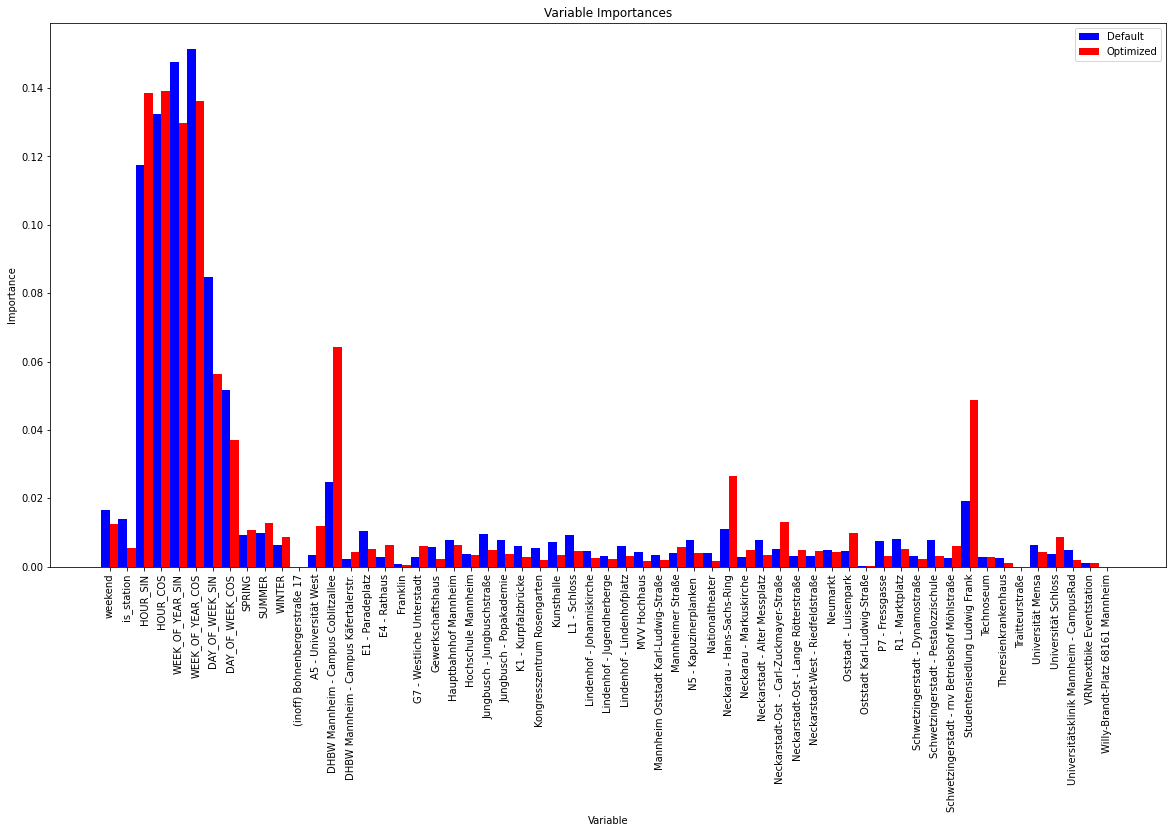

In [53]:
# Creating fig
fig = plt.figure(figsize=(20, 10))

# Deriving the feature importances of the optimized and default model
default_importances = list(rf_model.feature_importances_)
optimized_importances = list(rf_mode_opt.feature_importances_)

# Creating an array with range of number of variables
x_values = np.arange(len(default_importances))

# Creating bar plots of optimized and default importances
plt.bar(x_values, default_importances,orientation='vertical', color='blue', width=.5, align='center', label='Default')
plt.bar(x_values + 0.5, optimized_importances, orientation='vertical', color='red', width=.5, align='center', label='Optimized')

plt.xticks(x_values + 0.25, list(X.columns), rotation='vertical')

plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')

plt.legend(loc=1)
plt.show();

In [54]:
#from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(20, 90, num = 8)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#print(random_grid)

In [55]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
#rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_random.fit(X_train, y_train)

In [56]:
#rf_random.best_params_